In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import struct
from vpython import *
import cv2

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
import HEAD_RECON

In [8]:
head =HEAD_RECON.threeD_head.read_from_file(3,6)



In [9]:
#head.sparsify(0.3)
head.filter_nan()
head.filter_depth(1.5)
head.center()

In [10]:
head.create_vpython_spheres()
head.save()

In [11]:
plt.show()

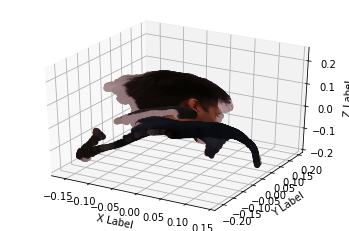

In [12]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

ax.scatter(head.xyz[:,0], -head.xyz[:,2], -head.xyz[:,1], c=head.rgb)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [13]:
head.xy_mesh

array([ 97607,  97608,  97609, ..., 307003, 307004, 307005])

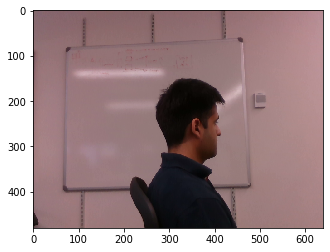

In [14]:
plt.imshow(head.twoD_image)

In [15]:
im = head.get_filtered_image()

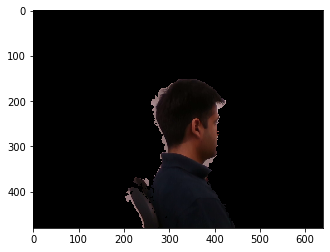

In [16]:
plt.imshow(im)

In [17]:
head.save()

In [18]:
im_save_path = "head_3_6.png"
plt.imsave(im_save_path,im)

In [147]:
img1 = HEAD_RECON.threeD_head.read_from_file(2,3).get_filtered_image()
img2 = HEAD_RECON.threeD_head.read_from_file(2,4).get_filtered_image()

In [148]:
plt.imsave("head_2_1.png",img1)
plt.imsave("head_2_2.png",img2)

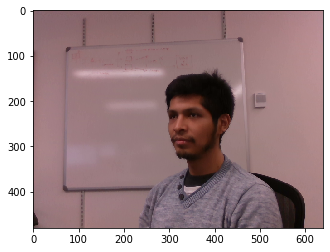

In [149]:
plt.imshow(img2)

In [150]:
# Find SIFT descriptors and match
img1 = cv2.imread('head_2_1.png')
img2 = cv2.imread('head_2_2.png')

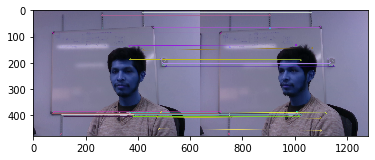

In [151]:
# test
kp1, des1 = HEAD_RECON.estimate_frame_transform.get_descriptors("head_2_1.png")
kp2, des2 = HEAD_RECON.estimate_frame_transform.get_descriptors("head_2_2.png")

good,good_without_list = HEAD_RECON.estimate_frame_transform.get_matched_points(img1,kp1,des1,img2,kp2,des2)

In [152]:
len(good_without_list)

27

In [153]:
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

In [154]:
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

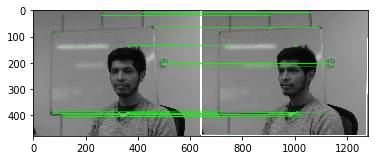

In [156]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good_without_list,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()
plt.imsave("transform.png",img3)